In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'


In [2]:

#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col, regexp_replace, when

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Products Analysis") \
    .getOrCreate()

In [5]:
# Read the CSV data
def clean_price(price_col):
    return regexp_replace(col(price_col), '₹|,', '').cast('double')

# Read and process the data
df = spark.read.csv('file:///home/talentum/test-jupyter/test/sales.csv', header=True, inferSchema=True)
df = df.withColumn('discount_price', clean_price('discount_price')) \
      .withColumn('actual_price', clean_price('actual_price'))


In [6]:
# Calculate discount percentage
df = df.withColumn('discount_percentage', 
    ((col('actual_price') - col('discount_price')) / col('actual_price') * 100))


In [7]:
# Convert ratings and number of ratings to numeric
df = df.withColumn('ratings', col('ratings').cast('double'))
df = df.withColumn('no_of_ratings', 
    when(col('no_of_ratings').isNull(), 0)
    .otherwise(col('no_of_ratings').cast('int')))



In [8]:
# Basic statistics
basic_stats = df.select(['discount_price', 'actual_price', 'ratings', 'discount_percentage']) \
    .summary("count", "mean", "stddev", "min", "max")

basic_stats.show()

+-------+------------------+----------------+------------------+-------------------+
|summary|    discount_price|    actual_price|           ratings|discount_percentage|
+-------+------------------+----------------+------------------+-------------------+
|  count|               457|             500|               423|                457|
|   mean| 40756.00656455142|     54815.22724|3.8096926713948003|  29.74994154602051|
| stddev|14961.100450086831|22756.9121001554|0.7896100484087444|  12.79531993457441|
|    min|             199.0|           499.0|               1.0| 0.8759124087591241|
|    max|          128800.0|        149000.0|               5.0| 60.120240480961925|
+-------+------------------+----------------+------------------+-------------------+



In [9]:
# Convert to Pandas for visualization
pdf = df.toPandas()



In [10]:
# Set up the plotting style
plt.style.use('seaborn')
sns.set_palette("husl")



/home/talentum/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/talentum/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8377 missing from current font.
  font.set_text(s, 0, flags=flags)


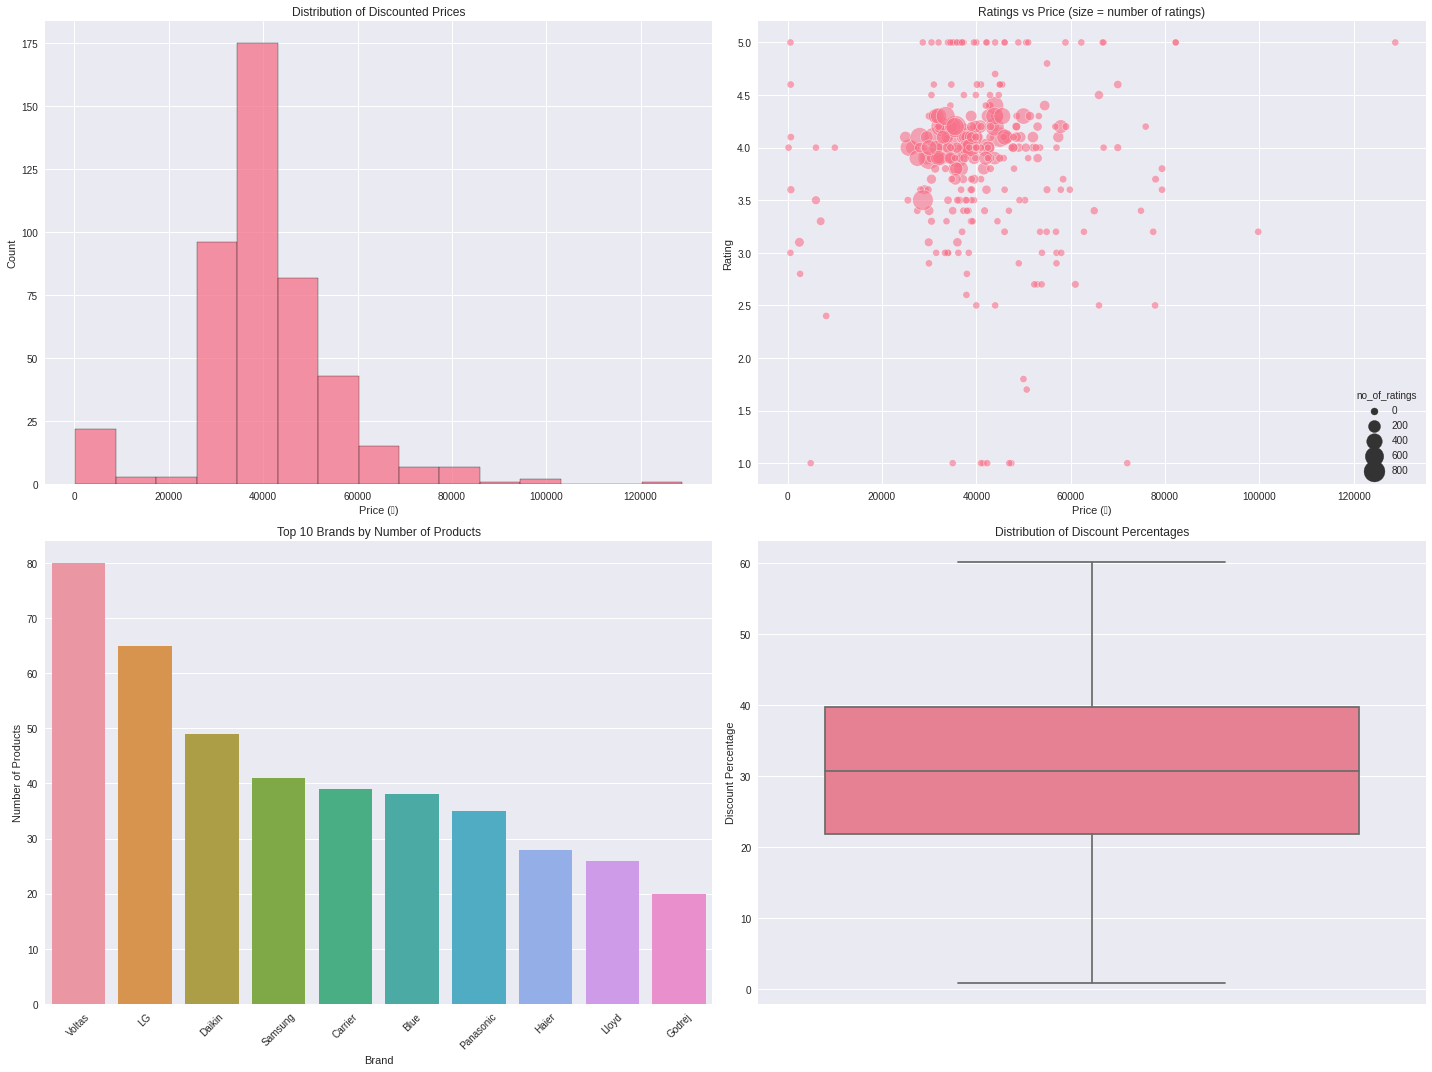

In [11]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Price Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=pdf, x='discount_price', bins=15)
plt.title('Distribution of Discounted Prices')
plt.xlabel('Price (₹)')
plt.ylabel('Count')

# 2. Ratings vs Price Scatter Plot
plt.subplot(2, 2, 2)
sns.scatterplot(data=pdf, x='discount_price', y='ratings', size='no_of_ratings', 
                sizes=(50, 500), alpha=0.6)
plt.title('Ratings vs Price (size = number of ratings)')
plt.xlabel('Price (₹)')
plt.ylabel('Rating')

# 3. Brand Analysis
plt.subplot(2, 2, 3)
brand_avg_price = pdf['name'].str.split().str[0].value_counts().head(10)
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values)
plt.title('Top 10 Brands by Number of Products')
plt.xticks(rotation=45)
plt.xlabel('Brand')
plt.ylabel('Number of Products')

# 4. Discount Percentage Distribution
plt.subplot(2, 2, 4)
sns.boxplot(data=pdf, y='discount_percentage')
plt.title('Distribution of Discount Percentages')
plt.ylabel('Discount Percentage')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [12]:
import pyspark.sql.functions as F

# Additional Analysis: Brand-wise average ratings and prices
brand_analysis = df.withColumn('brand', F.split(col('name'), ' ').getItem(0)) \
    .groupBy('brand') \
    .agg(
        F.avg('ratings').alias('avg_rating'),
        F.avg('discount_price').alias('avg_price'),
        F.count('*').alias('product_count')
    ) \
    .filter(col('product_count') > 1) \
    .orderBy('avg_rating', ascending=False)

# Print the results
print("\nBrand-wise Analysis:")
brand_analysis.show()

# Stop Spark session
spark.stop()

<Figure size 576x396 with 0 Axes>


Brand-wise Analysis:
+-------------+------------------+------------------+-------------+
|        brand|        avg_rating|         avg_price|product_count|
+-------------+------------------+------------------+-------------+
|       SUHANA|               5.0|38333.333333333336|            3|
|        ONIDA|               5.0|           32490.0|            2|
|      Oneiric|               5.0|              null|            4|
|           AC|               5.0|             899.5|            3|
|            1|               5.0|              null|            3|
|   Electrolux|              4.45|           44190.0|            5|
|     OGENERAL|               4.3|           55220.0|            2|
|Havells-Lloyd|               4.3|           34900.0|            4|
|            O|              4.25|           61130.0|            3|
|    Panasonic| 4.234782608695652| 45933.27272727273|           35|
|        Midea| 4.233333333333333|40169.666666666664|            3|
|     OGeneral|           